In [6]:
from IPython.display import Image
Image(url='http://mechanicalforex.com/wp-content/uploads/2011/06/NN.png', width=400, height=600)

## In this notebook, we will train several convolutional neural networks (cNN) for classification and regression

The style of this approach is taken from this guide: http://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb 

## 1) Background

#### Type of Analytic Question

Here we will attempt to classify molecules as either actyive or inactive using a set of molecular descriptors

#### Metric of Success

For the classification problem, we can use accuracy - the fraction of correctly classified compounds - as a measure of how well the model of choice is performing. For the regression problem, we may chose from various scoring methods

#### Context for question and the scientific application

This will serve as practic for building and testing a model(s). The comparative 
success of the different models tested will aid in choosing which model to use in future analysis of this type of data.


### Dataset 

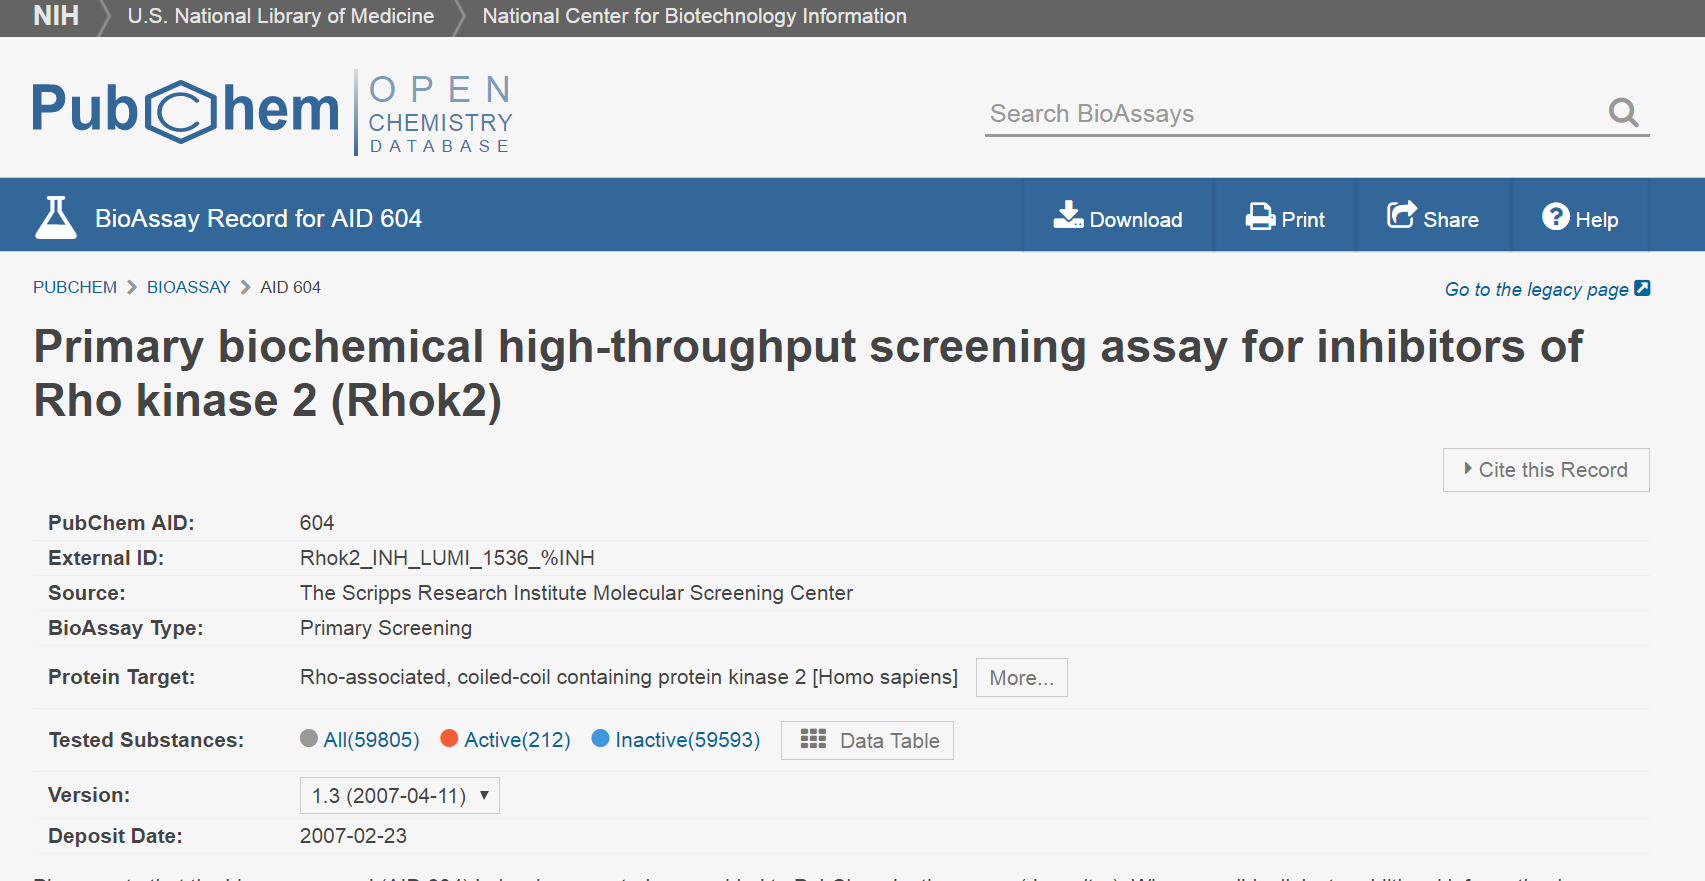

In [13]:
Image('pubchem_rhk2_pic.png', width=900, height=900)

### About the Data

source: https://pubchem.ncbi.nlm.nih.gov/bioassay/604#section=Top

"Source (MLSCN Center Name): The Scripps Research Institute Molecular Screening Center
Center Affiliation: The Scripps Research Institute, TSRI
Assay Provider: Scripps Florida
Network: Molecular Library Screening Center Network (MLSCN)
Grant Proposal Number: NA

External Assay ID: Rhok2_INH_LUMI_1536_%INH

Name:
Primary biochemical high-throughput screening assay for inhibitors of Rho kinase 2 (Rhok2)

Description:

Rho-Kinase is a serine/threonine kinase that is involved in the regulation of smooth muscle contraction and cytoskeletal reorganization of nonmuscle cells (1). Small-molecule inhibitors of Rho-Kinase, which promote smooth muscle relaxation, may be effective for treatment of cerebral vasospasm (2) and potentially effective for treatment of angina (3), hypertension (4), arteriosclerosis (5), and erectile dysfunction (6).

References:

[1] Trauger JW, Lin FF, Turner MS, Stephens J, LoGrasso PV. Kinetic mechanism for human Rho-Kinase II (ROCK-II).Biochemistry. 2002 Jul 16;41(28):8948-53. 

[2] Shibuya, M., et al. Effect of AT877 on cerebral vasospasm after aneurysmal subarachnoid hemorrhage. Results of a prospective placebo-controlled double-blind trial. J Neurosurg. 1992 Apr;76(4):571-7.

[3] Utsunomiya, T., et al. Antianginal effects of hydroxyfasudil, a Rho-kinase inhibitor, in a canine model of effort angina. Br J Pharmacol. 2001 Dec;134(8):1724-30. 

[4] Uehata, M., et al. Calcium sensitization of smooth muscle mediated by a Rho-associated protein kinase in hypertension. Nature. 1997 Oct 30;389(6654):990-4.

[5] Shimokawa, H., et al. Long-term inhibition of Rho-kinase induces a regression of arteriosclerotic coronary lesions in a porcine model in vivo. Cardiovasc Res. 2001 Jul;51(1):169-77. 

[6] Chitaley, K., et al. Inhibition of lymphangiogenesis with resulting lymphedema in transgenic mice expressing soluble VEGF receptor-3. Nat Med. 2001 Feb;7(2):199-205. "


##### Key points at a glance:

Preliminary screen - may contain false positives* 

Total # of compounds: 59,805

Total # of "active" compounds: 212 

% Active = .35%

##### "Active": 

Prior to inhibition calculations, background signal (i.e. signal from wells containing all reagents except enzyme) was subtracted from test compound and control well values. To calculate percent inhibition the test compound well signal was divided by the median signal from the 100 percent inhibition positive control wells (i.e. wells containing Y-27632) and multiplied by 100.

##### A mathematical algorithm was used to determine nominally inhibitory compounds in the primary screen. Two values were calculated: (1) the average percent inhibition of all compounds tested, and (2) three times their standard deviation. The sum of these two values was used as a cutoff parameter, i.e. any compound that exhibited greater %inhibition than the cutoff parameter was declared active.

The reported Pubchem_Activity_Score has been normalized to 100% of the highest observed primary inhibition. Negative % inhibition values are reported as activity score zero.

*Virtual Screening of Bioassay Data Amanda C Schierz,Smart Technology Research Centre, Bournemouth University, Talbot Campus, Poole, Dorset, BH12 5BB, UK Journal of Cheminformatics 2009, 1:21 doi:10.1186/1758-2946-1-21)


## 2) Checking the Data 

In [2]:
import numpy as np
import pandas as pd


#### Image data

In [2]:
data = np.genfromtxt("extended_batch_1.csv", delimiter=',')

print("the shape of our data: " + str(data.shape))
print(str(data[0]))
print("the max value of our data: " + str(np.amax(data)))
print("the min value of our data: " + str(np.amin(data)))

the shape of our data: (10128, 10000)
[ 0.91379309  0.91379309  0.91379309 ...,  0.91379309  0.91379309
  0.91379309]
the max value of our data: 1.0
the min value of our data: 0.0


#### labels/targets

In [3]:
labels = np.genfromtxt("labels_set_1.csv", delimiter=',')

In [5]:
print("the shape of our data: " + str(labels.shape))
print(str(labels[0]))


the shape of our data: (10158, 2)
[ 0.  0.]


In [6]:
short_labels = labels[:-30]
len(short_labels)

10128

In [7]:
short_labels

array([[   0.,    0.],
       [   1.,    0.],
       [   2.,    0.],
       ..., 
       [ 125.,    1.],
       [ 126.,    1.],
       [ 127.,    1.]])

In [16]:
df = pd.read_csv("labels_set_1.csv", header=0)
df = df['0.1']
df = list(df)
len(df)

10157

In [17]:
labels_1 = df[:-29]

In [18]:
len(labels_1)

10128

In [1]:
# labels_1 = targets
# data = pixel input data for compound images


## 3) Building our Neural Net

In [8]:
import theano

from nolearn.lasagne import NeuralNet #neural net constructor

from lasagne.objectives import squared_error
from lasagne.nonlinearities import softmax
from lasagne import layers
from lasagne.updates import nesterov_momentum

from sklearn.cross_validation import train_test_split

C:\Users\Egbert\Anaconda3\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_1, test_size=0.33, random_state=42)

#convert data to 2D
def convto2D(data):
    newData = data.reshape(-1,1,100,100)
    return newData

newData = convto2D(X_train)

print(np.shape(X_train))
print(np.shape(newData))


NameError: name 'data' is not defined

In [ ]:
conv_net_1 = NeuralNet( 
    layers =[
        ('input', layersInputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 100, 100),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=10, output_nonlinearity=softmax,
    
    update_learning_rate=0.01,
    update_momentum=0.9,
    
    max_epochs=12,
    verbose=1, 
    )

net2.fit(newData, y_train)

In [10]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(conv_net_1)

ImportError: No module named 'cPickle'

In [11]:
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity

ImportError: No module named 'cPickle'

In [12]:
plot_conv_activity(conv_net_1.layers_[1], newData[0:1])

NameError: name 'plot_conv_activity' is not defined

In [13]:
plot_conv_activity(conv_net_1.layers_[3], newData[0:1])

NameError: name 'plot_conv_activity' is not defined

In [14]:
plot_conv_activity(conv_net_1.layers_[5], newData[0:1])

NameError: name 'plot_conv_activity' is not defined